# Geostructures: Working with Coordinates and Shapes

This notebook will demonstrate:
* Coordinates
* Creating shapes
* Bounding shapes by time
* Shape operations
* Converting shapes into alternate formats

In [1]:
# If you've git cloned this repo, run this cell to add `geostructures` to your python path
import sys
sys.path.insert(0, '../')

In [2]:
from datetime import datetime

from geostructures import *
from geostructures.time import TimeInterval
from geostructures.visualization.plotly import draw_collection

## Coordinates

Geostructures provides a `Coordinate` object that can be instanced with the longitude and latitude (in that order). It's important to note that geostructures expects all coordinates to be defined using the WGS84 standard.

In [3]:
# All of these are equivalent
centroid = Coordinate(-0.118092, 51.509865)
centroid = Coordinate('-0.118092', '51.509865')
centroid = Coordinate(
    longitude=-0.118092, 
    latitude=51.509865
)

### Working with alternate formats

Coordinates are most often found in decimal format, but many different systems exist. Geostructures can create coordinates from and convert them back to:
* Degrees, minutes, seconds
* Quadrant format
* MGRS

In [4]:
centroid = Coordinate.from_dms(
    (0, 7, 5.1312, 'W'), (51, 30, 35.514, 'N')  # degrees, minutes, seconds
)

centroid = Coordinate.from_qdms(
    'W000070513',
    'N51303551'
)

centroid = Coordinate.from_mgrs('30UXC9997810464')

In [5]:
print("Degrees, minutes, seconds:", centroid.to_dms())
print("Quadrant format:", centroid.to_qdms())
print("MGRS:", centroid.to_mgrs())

Degrees, minutes, seconds: ((0, 7, 5.18336, 'W'), (51, 30, 35.50505, 'N'))
Quadrant format: ('W000070518', 'N51303551')
MGRS: 30UXC9997810464


## Creating Shapes

Geostructures are created using the bare minimum information needed - there's no need to calculate bounding points. We define each shape according to its mathematical definition up until we need to convert it to be used by something else (for example, a well known text string)

Geostructures currently supports the following shapes:
* GeoBox: a square, defined by its northwest and southeast coordinates. Note that because of the curvature of the earth, this shape will in reality be trapezoidal
* GeoCircle: a perfect circle, defined by a centerpoint and radius
* GeoEllipse: an oval, defined by a centerpoint, major axis, minor axis, and rotation
* GeoRing: a perfect ring, defined by a centerpoint, inner radius, and outer radius. You can also create a Wedge shape by passing values to the angle_min and angle_max parameters
* GeoLineString: a path, defined by an ordered series of coordinates**
* GeoPoint: a single point

Geostructures defines all distance measurements in meters, and all angles are relative to true north.

**When working with Linestrings, keep in mind that bounding a linestring by time applies to all coordinates in the linestring. If your points each have associated times, you may want to use the `geostructures.collections.Track` object instead.

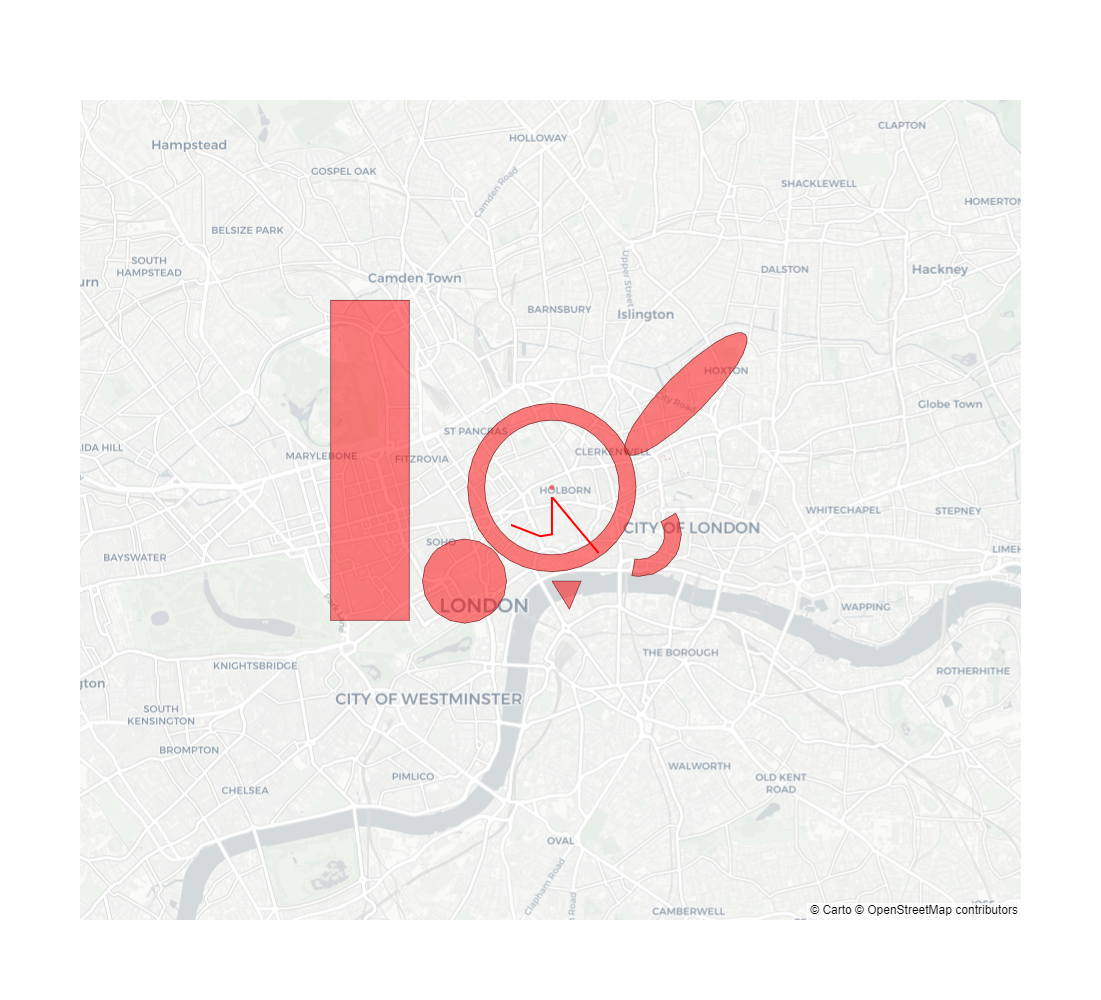

In [9]:
from geostructures import *
from geostructures.collections import FeatureCollection
from geostructures.time import TimeInterval

box = GeoBox(
    Coordinate(-0.154092, 51.539865),  # Northwest corner
    Coordinate(-0.140592, 51.505665)    # Southeast corner
)

circle = GeoCircle(Coordinate(-0.131092, 51.509865), radius=500)

ellipse = GeoEllipse(
    Coordinate(-0.093092, 51.529865), 
    semi_major=1_000, # The distance between the centerpoint and the furthest point along the circumference
    semi_minor=250,   # The distance between the centerpoint and the closest point along the circumference
    rotation=45       # The angle of rotation (between 0 and 360)
)

ring = GeoRing(
    Coordinate(-0.116092, 51.519865),
    inner_radius=800,
    outer_radius=1000,
)

wedge = GeoRing(
    Coordinate(-0.101092, 51.514865),
    inner_radius=300,
    outer_radius=500,
    angle_min=60,    # The minimum angle of the wedge
    angle_max=190,   # The maximum angle of the wedge
)

linestring = GeoLineString(
    [
        Coordinate(-0.123092, 51.515865), Coordinate(-0.118092, 51.514665), Coordinate(-0.116092, 51.514865),
        Coordinate(-0.116092, 51.518865), Coordinate(-0.108092, 51.512865)
    ]
)

point = GeoPoint(Coordinate(-0.116092, 51.519865))

polygon = GeoPolygon(
    [
        Coordinate(-0.116092, 51.509865), Coordinate(-0.113092, 51.506865), 
        Coordinate(-0.111092, 51.509865), Coordinate(-0.116092, 51.509865)  # Note that the last coordinate is the same as the first
    ]
)

collection = FeatureCollection([box, circle, ellipse, ring, wedge, linestring, point, polygon])
fig=draw_collection(collection)
fig.update_layout(height=1000)

### Defining Holes in Shapes

Geostructures makes it similarly easy to define shapes with holes - just use another shape!

In [ ]:
circle_w_hole = GeoCircle(
    Coordinate(-0.131092, 51.509865),
    radius=500,
    holes=[
        GeoEllipse(Coordinate(-0.131092, 51.509865), 200, 100, 75)
    ]
)
draw_collection(FeatureCollection([circle_w_hole]))

#### Quick note: The GeoJSON Right Hand Rule

GeoJSON's spec (and really most other standards too) demands that all shapes' outer shells be defined in counter-clockwise order, and all holes be defined in clockwise order. Geostructures handles this for you and will invert the coordinate order if it finds a violation.

In [ ]:
# Will throw a warning and then invert the coordinate order
polygon = GeoPolygon(
    [
        Coordinate(-0.116092, 51.509865), Coordinate(-0.111092, 51.509865), 
        Coordinate(-0.113092, 51.506865), Coordinate(-0.116092, 51.509865)  # Note that the last coordinate is the same as the first
    ]
)

## Bounding Shapes by Time

Geostructures allows you to define shapes by a point or interval in time using the `dt` parameter. This effectively adds a third axis, so bounding a shape this way will affect how geometric operations (such as `contains` or `intersects`) occur.

We always recommend using UTC time, so any time property passed will default to UTC unless you've already specified otherwise

In [ ]:
# This circle is 'timeless', which is functionally equivalent to eternal
circle = GeoCircle(
    Coordinate(-0.118092, 51.509865), 
    radius=5000
)

# This circle only exists at midnight, January 1st 2020
circle = GeoCircle(
    Coordinate(-0.118092, 51.509865), 
    radius=5000, 
    dt=datetime(2020, 1, 1)
)

# This circle exists between midnight, January 1st 2020 and noon, January 3rd 2020
circle2 = GeoCircle(
    Coordinate(-0.118092, 51.509865), 
    radius=5000, 
    dt=TimeInterval(datetime(2020, 1, 1), datetime(2020, 1, 3, 12))
)

In [ ]:
print("January 2 point inside circle?", GeoPoint(Coordinate(-0.118092, 51.509865), dt=datetime(2020, 1, 2)) in circle2)
print("January 5 point inside circle?", GeoPoint(Coordinate(-0.118092, 51.509865), dt=datetime(2020, 1, 5)) in circle2)

# Shape Operations

Each geostructure comes with several geometric operations you can apply:
* Calculate the centroid, area (meters squared) and volume (meters squared seconds)
* Draw a circumscribing circle or rectangle around the shape
* Create a list of coordinates that define the outermost border and any holes present
* Test whether a point falls within the shape

### Centroid, Area, and Volume

In [ ]:
polygon = GeoPolygon(
    [
        Coordinate(-0.116092, 51.509865), Coordinate(-0.113092, 51.506865), 
        Coordinate(-0.111092, 51.509865), Coordinate(-0.116092, 51.509865)  # Note that the last coordinate is the same as the first
    ],
    dt=TimeInterval(datetime(2020, 1, 1), datetime(2020, 1, 2))
)

print("Centroid:", polygon.centroid)

# The area of the shape across the spatial plane, in meters squared
print("Area:", polygon.area)

# The volume of the shape across the spatial and time planes, in meters squared seconds (accurate to microseconds)
print("Volume:", polygon.volume)

### Circumscribing Circles and Rectangles

In [ ]:
circle_around_polygon = polygon.circumscribing_circle()
box_around_polygon = polygon.circumscribing_rectangle()

draw_collection(FeatureCollection([polygon, circle_around_polygon, box_around_polygon]))

### Bounding Coordinates and Linear Rings

Note: the term "bounding coordinates" is used to refer to the *outermost shell only*, whereas "linear rings" is inclusive of any holes present.

In [ ]:
# Will produce a list of the coordinates that comprise the outer shell of the shape
circle_around_polygon.bounding_coords()

In [ ]:
# Note that we have a list of two rings now - the first element will always be the bounding coordinates, and the following
# elements will always be the holes
circle_w_hole.linear_rings()

### Intersects, Contains, and Point in Polygon

You can also test shape/time intersection in geostructures using:

* `.intersects_time()` - tests only the time dimension
* `.intersects_shape()` - tests only the spatial dimensions
* `.intersects()` - equivalent to .intersects_time() and .intersects_shape()

The same three methods exist for `contains()` as well

In [ ]:
circle1 = GeoCircle(
    Coordinate(-0.118072, 51.509875), 
    5000, 
    dt=TimeInterval(datetime(2020, 1, 2), datetime(2020, 1, 3))
)  

# Test whether two shapes intersect across spatial and time bounds
circle2 = GeoCircle(
    Coordinate(-0.118072, 51.509875), # same centerpoint as circle1
    500, 
    dt=TimeInterval(datetime(2020, 1, 2, 12), datetime(2020, 1, 3, 12))
)        
print("Do these circles intersect in time?", circle1.intersects_time(circle2.dt))
print("Do these circles intersect in space?", circle1.intersects_shape(circle2))
print("Do these circles intersect in both?", circle1.intersects(circle2))

# Test whether one shape contains another
circle2 = GeoCircle(Coordinate(-0.118092, 51.509865), 100, dt=TimeInterval(datetime(2020, 1, 2, 12), datetime(2020, 1, 2, 13)))        
print("Does circle1 contain circle2?", circle1.contains(circle2))

### Shape Conversions

When you work with other Python libraries, you'll very often need to convert your geostructures into any number of formats. Geostructures provides easy methods for converting shapes into:
* GeoJSON
* Python Shapely objects
* Well Known Text (WKT)

Where supported, any properties given to your geoshape will be injected into the resulting data format. If you've bound your shapes by time, the resulting properties will be named `datetime_start` and `datetime_end`.

#### Converting to GeoJSON

In [ ]:
polygon = GeoPolygon(
    [
        Coordinate(0.0, 1.0), Coordinate(1.0, 1.0), 
        Coordinate(0.5, 0.0), Coordinate(0.0, 1.0)  # Note that the last coordinate is the same as the first
    ],
    dt=TimeInterval(datetime(2020, 1, 1), datetime(2020, 1, 2)),
    properties={'example property': 'example value'}
)

# With GeoJSON, you can also specify 'root-level' properties to inject
polygon.to_geojson(root_level_property='another example')

#### Converting to WKT

In [ ]:
polygon.to_wkt()

#### Converting to Shapely Objects

In [ ]:
polygon.to_shapely()